In [ ]:
# import packages
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
import numpy as np
import pandas as pd
import time

import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 14 04:04:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Step #1: Preprocessing the Dataset for Time Series Analysis

In [ ]:
travel_time_df = pd.read_csv('/content/drive/MyDrive/CIS 545 Project Folder/Data Set/2021_travel_time.csv')
corridor_file = "/content/drive/MyDrive/CIS 545 Project Folder/Data Set/pems_district4_corridors.csv"
corridor_df = pd.read_csv(corridor_file)

travel_time_df = travel_time_df[travel_time_df['5 Minutes'] > '2021-1-01 00:00:00']

In [ ]:
corridors_to_merge = []

for row_num, corridor in corridor_df.iterrows():  	
      if row_num == 0:
          all_corridors_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
      else:
          corridor_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
          all_corridors_tt_2021 = all_corridors_tt_2021.merge(corridor_tt_2021, "outer", left_on='5 Minutes', right_on='5 Minutes')

In [ ]:
all_corridors_tt_2021 = all_corridors_tt_2021.dropna(axis=1)
all_corridors_tt_2021

,5 Minutes,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y
0,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
1,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
2,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
3,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
4,2021-10-01 00:00:00,10.90,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55868,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55869,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55870,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72


In [ ]:
new_columns = [f"travel_time_{n}" for n in range(len(all_corridors_tt_2021.columns) - 1)]
new_columns.insert(0, "timestamp")
# len(new_columns)
all_corridors_tt_2021 = all_corridors_tt_2021.set_axis(new_columns, axis=1, inplace=False)
num_records, num_corridors = all_corridors_tt_2021.shape

In [ ]:
all_corridors_tt_2021.head(10)

,timestamp,travel_time_0,travel_time_1,travel_time_2,travel_time_3,travel_time_4,travel_time_5,travel_time_6,travel_time_7,travel_time_8,travel_time_9,travel_time_10,travel_time_11,travel_time_12,travel_time_13,travel_time_14,travel_time_15,travel_time_16,travel_time_17,travel_time_18,travel_time_19,travel_time_20,travel_time_21,travel_time_22,travel_time_23,travel_time_24,travel_time_25,travel_time_26,travel_time_27,travel_time_28,travel_time_29,travel_time_30,travel_time_31,travel_time_32,travel_time_33,travel_time_34,travel_time_35,travel_time_36,travel_time_37,travel_time_38,travel_time_39,travel_time_40
0,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
1,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
2,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
3,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
4,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
5,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
6,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
7,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
8,2021-10-01 00:05:00,10.9,11.58,5.32,10.62,4.15,4.23,1.28,1.25,13.38,13.05,6.47,6.08,4.22,4.63,3.57,3.57,27.75,11.93,11.98,12.02,7.62,17.98,14.83,3.22,3.30,12.43,12.33,8.28,8.20,17.13,12.17,13.92,13.93,18.33,18.78,25.48,25.58,5.75,6.08,15.70,15.80
9,2021-10-01 00:05:00,10.9,11.58,5.32,10.62,4.15,4.23,1.28,1.25,13.38,13.05,6.47,6.08,4.22,4.63,3.57,3.57,27.75,11.93,11.98,12.02,7.62,17.98,14.83,3.22,3.30,12.43,12.33,8.28,8.20,17.13,12.17,13.92,13.93,18.33,18.78,25.48,25.58,5.75,6.08,15.70,15.80


In [ ]:
def make_dataset_many_to_one(array,time_steps, num_sample, Horizon = 0):

    x = []
    y = []

    indices = random.sample(range(time_steps, len(array) - Horizon), num_sample)

    for i in indices:
        x.append(array[i-time_steps:i])
        y.append(array[i + Horizon])
        
    return np.array(x), np.array(y)

# train_data = all_corridors_tt_2021.drop(['timestamp'], axis=1).iloc[:num_training]
total_data = all_corridors_tt_2021.drop(['timestamp'], axis=1)
 #for testing at bottom
print(total_data)

       travel_time_0  travel_time_1  ...  travel_time_39  travel_time_40
0              10.90          11.55  ...           15.75           15.78
1              10.90          11.55  ...           15.75           15.78
2              10.90          11.55  ...           15.75           15.78
3              10.90          11.55  ...           15.75           15.78
4              10.90          11.55  ...           15.75           15.78
...              ...            ...  ...             ...             ...
55867          10.88          11.60  ...           15.70           15.72
55868          10.88          11.60  ...           15.70           15.72
55869          10.88          11.60  ...           15.70           15.72
55870          10.88          11.60  ...           15.70           15.72
55871          10.88          11.60  ...           15.70           15.72

[55872 rows x 41 columns]


In [ ]:
import random
#scale values to [0,1]
num_training = 16000
num_validate = 4000
num_test = 4000
time_steps = 24  # 2 hours
num_corridor = total_data.shape[1]
hidden_size = 120
nfc = 512            # fully connected layer for attention
drop_prob = 0.5

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit_transform(total_data)
# train = scaler.transform(train_data)
total = scaler.transform(total_data)

sc = MinMaxScaler()
total_data = sc.fit_transform(total_data)

## 15 minutes horizon
trn_x, trn_y = make_dataset_many_to_one(total, time_steps, num_training)  
vld_x, vld_y = make_dataset_many_to_one(total, time_steps, num_validate)  
tst_x, tst_y = make_dataset_many_to_one(total, time_steps, num_test)  

trn_x = trn_x.reshape(-1, time_steps, num_corridor)
vld_x = vld_x.reshape(-1, time_steps, num_corridor)
tst_x = tst_x.reshape(-1, time_steps, num_corridor)

In [ ]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
model = Sequential()
model.add(LSTM(hidden_size, return_sequences=True, input_shape=(time_steps, num_corridor))) # returns a sequence of vectors of dimension 32
model.add(LSTM(hidden_size))  
model.add(Dropout(0.1))
model.add(Dense(nfc))
model.add(Dropout(0.1))
model.add(Dense(num_corridor))

start = time.time()
model.compile(loss='mse', optimizer='adam')

history = model.fit(trn_x, trn_y, validation_split = 0.25, epochs=1000, batch_size=50, verbose=1)

end = time.time()
print('time %.2f sec' % (end-start))

Epoch 1/1000
240/240 [==============================] - 6s 11ms/step - loss: 0.0014 - val_loss: 4.6524e-04
Epoch 2/1000
240/240 [==============================] - 2s 7ms/step - loss: 6.3304e-04 - val_loss: 3.6041e-04
Epoch 3/1000
240/240 [==============================] - 2s 8ms/step - loss: 4.9870e-04 - val_loss: 2.7777e-04
Epoch 4/1000
240/240 [==============================] - 2s 7ms/step - loss: 4.5261e-04 - val_loss: 2.5761e-04
Epoch 5/1000
240/240 [==============================] - 2s 7ms/step - loss: 4.2721e-04 - val_loss: 2.1746e-04
Epoch 6/1000
240/240 [==============================] - 2s 7ms/step - loss: 3.9320e-04 - val_loss: 2.1820e-04
Epoch 7/1000
240/240 [==============================] - 2s 7ms/step - loss: 3.8462e-04 - val_loss: 1.7690e-04
Epoch 8/1000
240/240 [==============================] - 2s 8ms/step - loss: 3.7517e-04 - val_loss: 1.7518e-04
Epoch 9/1000
240/240 [==============================] - 2s 8ms/step - loss: 3.5854e-04 - val_loss: 2.0166e-04
Epoch 10/1000

In [ ]:
# list all data in history
print(history.history.keys())

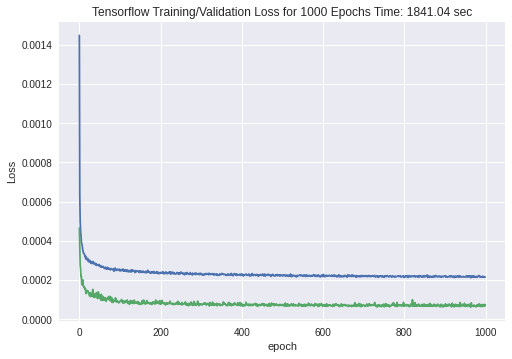

In [ ]:
# summarize history for loss
import matplotlib.pyplot as plt
plt.style.use('seaborn')
epochs = 1000
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Tensorflow Training/Validation Loss for {epochs} Epochs Time: {round(end-start, 2)} sec')
plt.ylabel('Loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
# Split into training, validation and test datasets.
# Since it's timeseries we should do it by date.
test_cutoff_date = df['date_time'].max() - timedelta(days=7)
val_cutoff_date = test_cutoff_date - timedelta(days=14)

df_test = df[df['date_time'] > test_cutoff_date]
df_val = df[(df['date_time'] > val_cutoff_date) & (df['date_time'] <= test_cutoff_date)]
df_train = df[df['date_time'] <= val_cutoff_date]

#check out the datasets
print('Test dates: {} to {}'.format(df_test['date_time'].min(), df_test['date_time'].max()))
print('Validation dates: {} to {}'.format(df_val['date_time'].min(), df_val['date_time'].max()))
print('Train dates: {} to {}'.format(df_train['date_time'].min(), df_train['date_time'].max()))

## Step 2: Transforming the Dataset for TensorFlow Keras

### Dividing the Dataset into Smaller Dataframes

In [ ]:
# Goal of the model:
#  Predict Global_active_power at a specified time in the future.
#   Eg. We want to predict how much Global_active_power will be ten minutes from now.
#       We can use all the values from t-1, t-2, t-3, .... t-history_length to predict t+10


def create_ts_files(dataset, 
                    start_index, 
                    end_index, 
                    history_length, 
                    step_size, 
                    target_step, 
                    num_rows_per_file, 
                    data_folder):
    assert step_size > 0
    assert start_index >= 0
    
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    
    time_lags = sorted(range(target_step+1, target_step+history_length+1, step_size), reverse=True)
    col_names = [f'x_lag{i}' for i in time_lags] + ['y']
    start_index = start_index + history_length
    if end_index is None:
        end_index = len(dataset) - target_step
    
    rng = range(start_index, end_index)
    num_rows = len(rng)
    num_files = math.ceil(num_rows/num_rows_per_file)
    
    # for each file.
    print(f'Creating {num_files} files.')
    for i in range(num_files):
        filename = f'{data_folder}/ts_file{i}.pkl'
        
        if i % 10 == 0:
            print(f'{filename}')
            
        # get the start and end indices.
        ind0 = i*num_rows_per_file
        ind1 = min(ind0 + num_rows_per_file, end_index)
        data_list = []
        
        # j in the current timestep. Will need j-n to j-1 for the history. And j + target_step for the target.
        for j in range(ind0, ind1):
            indices = range(j-1, j-history_length-1, -step_size)
            data = dataset[sorted(indices) + [j+target_step]]
            
            # append data to the list.
            data_list.append(data)

        df_ts = pd.DataFrame(data=data_list, columns=col_names)
        df_ts.to_pickle(filename)
            
    return len(col_names)-1

In [ ]:
%%time

global_active_power = df_train['Global_active_power'].values

# Scaled to work with Neural networks.
scaler = MinMaxScaler(feature_range=(0, 1))
global_active_power_scaled = scaler.fit_transform(global_active_power.reshape(-1, 1)).reshape(-1, )

history_length = 7*24*60  # The history length in minutes.
step_size = 10  # The sampling rate of the history. Eg. If step_size = 1, then values from every minute will be in the history.
                #                                       If step size = 10 then values every 10 minutes will be in the history.
target_step = 10  # The time step in the future to predict. Eg. If target_step = 0, then predict the next timestep after the end of the history period.
                  #                                             If target_step = 10 then predict 10 timesteps the next timestep (11 minutes after the end of history).

# The csv creation returns the number of rows and number of features. We need these values below.
num_timesteps = create_ts_files(global_active_power_scaled,
                                start_index=0,
                                end_index=None,
                                history_length=history_length,
                                step_size=step_size,
                                target_step=target_step,
                                num_rows_per_file=128*100,
                                data_folder='ts_data')

# I found that the easiest way to do time series with tensorflow is by creating pandas files with the lagged time steps (eg. x{t-1}, x{t-2}...) and 
# the value to predict y = x{t+n}. We tried doing it using TFRecords, but that API is not very intuitive and lacks working examples for time series.
# The resulting file using these parameters is over 17GB. If history_length is increased, or  step_size is decreased, it could get much bigger.
# Hard to fit into laptop memory, so need to use other means to load the data from the hard drive.

### Defining the Time Series Object Class

In [ ]:
#
# So we can handle loading the data in chunks from the hard drive instead of having to load everything into memory.
# 
# The reason we want to do this is so we can do custom processing on the data that we are feeding into the LSTM.
# LSTM requires a certain shape and it is tricky to get it right.
#
class TimeSeriesLoader:
    def __init__(self, ts_folder, filename_format):
        self.ts_folder = ts_folder
        
        # find the number of files.
        i = 0
        file_found = True
        while file_found:
            filename = self.ts_folder + '/' + filename_format.format(i)
            file_found = os.path.exists(filename)
            if file_found:
                i += 1
                
        self.num_files = i
        self.files_indices = np.arange(self.num_files)
        self.shuffle_chunks()
        
    def num_chunks(self):
        return self.num_files
    
    def get_chunk(self, idx):
        assert (idx >= 0) and (idx < self.num_files)
        
        ind = self.files_indices[idx]
        filename = self.ts_folder + '/' + filename_format.format(ind)
        df_ts = pd.read_pickle(filename)
        num_records = len(df_ts.index)
        
        features = df_ts.drop('y', axis=1).values
        target = df_ts['y'].values
        
        # reshape for input into LSTM. Batch major format.
        features_batchmajor = np.array(features).reshape(num_records, -1, 1)
        return features_batchmajor, target
    
    # this shuffles the order the chunks will be outputted from get_chunk.
    def shuffle_chunks(self):
        np.random.shuffle(self.files_indices)

In [ ]:
ts_folder = 'ts_data'
filename_format = 'ts_file{}.pkl'
tss = TimeSeriesLoader(ts_folder, filename_format)

## Step 3: Creating the LSTM Model

In [ ]:
# Create the Keras model.
# Use hyperparameter optimization if you have the time.

ts_inputs = tf.keras.Input(shape=(num_timesteps, 1))

# units=10 -> The cell and hidden states will be of dimension 10.
#             The number of parameters that need to be trained = 4*units*(units+2)
x = layers.LSTM(units=10)(ts_inputs)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

In [ ]:
# Specify the training configuration.
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

In [ ]:
model.summary()

In [ ]:
%%time

# train in batch sizes of 128.
BATCH_SIZE = 128
NUM_EPOCHS = 1000
NUM_CHUNKS = tss.num_chunks()

time_1 = time.time()

for epoch in range(NUM_EPOCHS):
    print('epoch #{}'.format(epoch))
    for i in range(NUM_CHUNKS):
        X, y = tss.get_chunk(i)
        
        # model.fit does train the model incrementally. ie. Can call multiple times in batches.
        # https://github.com/keras-team/keras/issues/4446
        model.fit(x=X, y=y, batch_size=BATCH_SIZE)
        
    # shuffle the chunks so they're not in the same order next time around.
    tss.shuffle_chunks()

time_2 = time.time()

print(f"time:{round(time_2 - time_1} secs", )

In [ ]:
# evaluate the model on the validation set.
#
# Create the validation CSV like we did before with the training.
global_active_power_val = df_val['Global_active_power'].values
global_active_power_val_scaled = scaler.transform(global_active_power_val.reshape(-1, 1)).reshape(-1, )

history_length = 7*24*60  # The history length in minutes.
step_size = 10  # The sampling rate of the history. Eg. If step_size = 1, then values from every minute will be in the history.
                #                                       If step size = 10 then values every 10 minutes will be in the history.
target_step = 10  # The time step in the future to predict. Eg. If target_step = 0, then predict the next timestep after the end of the history period.
                  #                                             If target_step = 10 then predict 10 timesteps the next timestep (11 minutes after the end of history).

# The csv creation returns the number of rows and number of features. We need these values below.
num_timesteps = create_ts_files(global_active_power_val_scaled,
                                start_index=0,
                                end_index=None,
                                history_length=history_length,
                                step_size=step_size,
                                target_step=target_step,
                                num_rows_per_file=128*100,
                                data_folder='ts_val_data')

In [ ]:
# If we assume that the validation dataset can fit into memory we can do this.
df_val_ts = pd.read_pickle('ts_val_data/ts_file0.pkl')

features = df_val_ts.drop('y', axis=1).values
features_arr = np.array(features)

# reshape for input into LSTM. Batch major format.
num_records = len(df_val_ts.index)
features_batchmajor = features_arr.reshape(num_records, -1, 1)


y_pred = model.predict(features_batchmajor).reshape(-1, )
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1 ,)

y_act = df_val_ts['y'].values
y_act = scaler.inverse_transform(y_act.reshape(-1, 1)).reshape(-1 ,)

print('validation mean squared error: {}'.format(mean_squared_error(y_act, y_pred)))

#baseline
y_pred_baseline = df_val_ts['x_lag11'].values
y_pred_baseline = scaler.inverse_transform(y_pred_baseline.reshape(-1, 1)).reshape(-1 ,)
print('validation baseline mean squared error: {}'.format(mean_squared_error(y_act, y_pred_baseline)))